<a href="https://colab.research.google.com/github/mcany-pia/defect-categorization/blob/main/Defects.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -U scikit-learn
!pip install pandas
!pip install numpy
!pip install matplotlib

In [176]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.preprocessing import LabelEncoder
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import learning_curve
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

Initially used numpy for reading csv but it gave error at line 38 because there was a comma. So i guess it is not for reading text. therefore used pandas.

In [194]:
# train data
vdf = pd.read_csv("defects.csv")
# test data
#tdf = pd.read_csv('CompleteDataset.csv', sep="|")
#tdf = tdf.sample(frac = 1, random_state=2).reset_index()
#print(tdf.head)
#Shuffling and splitting the dataset into 70% training and 30% testing
#tdf = tdf.groupby('super').apply(lambda x: x.sample(n=250)).reset_index(drop=True)

tdf, vdf = train_test_split(vdf, test_size=0.2, random_state=2, shuffle=True)

#tdf = vdf.iloc[:700]
#vdf = vdf.iloc[700:]



print(vdf.head)
print(tdf.head)

# Vectorization parameters
# Range (inclusive) of n-gram sizes for tokenizing text.
NGRAM_RANGE = (1, 2)

# Limit on the number of features. We use the top 20K features.
TOP_K = 20000

# Whether text should be split into word or character n-grams.
# One of 'word', 'char'.
TOKEN_MODE = 'word'

# Minimum document/corpus frequency below which a token will be discarded.
MIN_DOCUMENT_FREQUENCY = 2


<bound method NDFrame.head of                                                Summary Ambiguous Description  \
665          RC-UI: Clone error on Specifications page                    no   
888  PINT: Wrong error information is returned in c...                   yes   
753  PC - Patch results with null pointer exception...                    no   
780  PC UI - Unable to add a service/resource speci...                    no   
419  DPRMS-2.15.1 Wrong error information and statu...                    no   
..                                                 ...                   ...   
62           DCMJ - Workflow execution not found Error                    no   
18        Faveo - Complaint TicketCreate Trigger Issue                   yes   
901                   PAM - nullPointerException Error                    no   
890  DRCMS - Missing fields in physicalResourceSpec...                    no   
677               10 - Task is not shown in BackOffice                    no   

         

Get number of samples and words per sample to compare. Then using https://developers.google.com/machine-learning/guides/text-classification/step-2-5 decide to the model.

In [ ]:
rows = len(df)
total_words = df['summary'].apply(lambda x: len(str(x).split())).sum()
w_per_s = total_words / rows
w_per_s

10.276476471207495

Since it is less than 1500 we are going with MLP.

In [ ]:
def ngram_vectorize(train_texts, train_labels, val_texts):
    """Vectorizes texts as n-gram vectors.

    1 text = 1 tf-idf vector the length of vocabulary of unigrams + bigrams.

    # Arguments
        train_texts: list, training text strings.
        train_labels: np.ndarray, training labels.
        val_texts: list, validation text strings.

    # Returns
        x_train, x_val: vectorized training and validation texts
    """
    # Create keyword arguments to pass to the 'tf-idf' vectorizer.
    kwargs = {
            'ngram_range': NGRAM_RANGE,  # Use 1-grams + 2-grams.
            'dtype': 'int32',
            'strip_accents': 'unicode',
            'decode_error': 'replace',
            'analyzer': TOKEN_MODE,  # Split text into word tokens.
            'min_df': MIN_DOCUMENT_FREQUENCY,
    }
    vectorizer = TfidfVectorizer(**kwargs)

    # Learn vocabulary from training texts and vectorize training texts.
    x_train = vectorizer.fit_transform(train_texts)

    # Vectorize validation texts.
    x_val = vectorizer.transform(val_texts)

    # Select top 'k' of the vectorized features.
    selector = SelectKBest(f_classif, k=min(TOP_K, x_train.shape[1]))
    selector.fit(x_train, train_labels)
    x_train = selector.transform(x_train).astype('float32')
    x_val = selector.transform(x_val).astype('float32')
    return x_train, x_val

Berfore we fed model with data. We should tokenize. Then train with it.

In [196]:
# Define train_texts, train_labels, val_texts, and val_labels earlier
train_texts = tdf['Summary']
train_labels = tdf['Final Classification']
val_texts = vdf['Summary']
val_labels = vdf['Final Classification']
# Initialize a label encoder
label_encoder = LabelEncoder()

# Vectorize the texts using the function
x_train, x_val = ngram_vectorize(train_texts, train_labels, val_texts)
# Fit the encoder on the training labels and transform both train and validation labels
y_train_encoded = label_encoder.fit_transform(train_labels)
y_val_encoded = label_encoder.transform(val_labels)

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:2072: UserWarning: Only (<class 'numpy.float64'>, <class 'numpy.float32'>, <class 'numpy.float16'>) 'dtype' should be used. int32 'dtype' will be converted to np.float64.
  warnings.warn(


MLP:

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


Training Score (Accuracy): 0.9869451697127938
0.53125


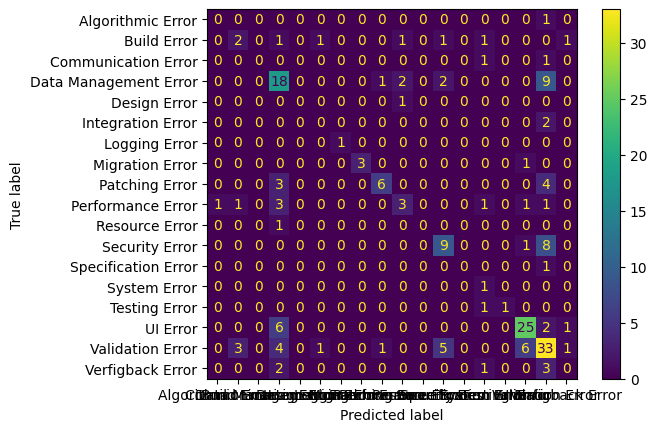

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.33      0.25      0.29         8
           2       0.00      0.00      0.00         2
           3       0.47      0.56      0.51        32
           4       0.00      0.00      0.00         1
           5       0.00      0.00      0.00         2
           6       1.00      1.00      1.00         1
           7       1.00      0.75      0.86         4
           8       0.75      0.46      0.57        13
           9       0.43      0.27      0.33        11
          10       0.00      0.00      0.00         1
          11       0.53      0.50      0.51        18
          12       0.00      0.00      0.00         1
          13       0.17      1.00      0.29         1
          14       1.00      0.50      0.67         2
          15       0.74      0.74      0.74        34
          16       0.51      0.61      0.55        54
          17       0.00    

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [197]:

# Initialize the MLP classifier
mlp_clf = MLPClassifier(hidden_layer_sizes=(50), max_iter=100, activation='relu', solver='adam', random_state=42)

# Train the model
mlp_clf.fit(x_train, y_train_encoded)

# Predict on the validation set
y_val_pred_mlp = mlp_clf.predict(x_val)

# Calculate the accuracy
training_score = mlp_clf.score(x_train, y_train_encoded)
print("Training Score (Accuracy):", training_score)


accuracy_mlp = accuracy_score(y_val_encoded, y_val_pred_mlp, normalize=True)
cm = confusion_matrix(y_val_encoded, y_val_pred_mlp)
fig = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=unique_classes)
fig.plot()
plt.show()

print(classification_report(y_val_encoded, y_val_pred_mlp))

SVM:

In [198]:
# Training the SVM classifier
svm = SVC(kernel='linear', random_state=42)
svm.fit(x_train, y_train_encoded)
y_val_pred_svm = svm.predict(x_val)

cross_val_accuracies = cross_val_score(svm, x_train, y_train_encoded, cv=5, scoring='accuracy')

# Compute mean and standard deviation of cross-validation accuracies
mean_cross_val_accuracy = cross_val_accuracies.mean()
std_cross_val_accuracy = cross_val_accuracies.std()
print("Cross-Validation Accuracies:", cross_val_accuracies)
print(mean_cross_val_accuracy)
print(std_cross_val_accuracy)


# Calculating accuracy and classification report for the SVM model
classification_rep_svm_test_new = classification_report(y_val_encoded, y_val_pred_svm, target_names=label_encoder.classes_)
print(classification_rep_svm_test_new)

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


Cross-Validation Accuracies: [0.45454545 0.50980392 0.5751634  0.48366013 0.52287582]
0.5092097445038621
0.04044246888053581
                       precision    recall  f1-score   support

    Algorithmic Error       0.00      0.00      0.00         1
          Build Error       0.40      0.25      0.31         8
  Communication Error       0.00      0.00      0.00         2
Data Management Error       0.40      0.62      0.49        32
         Design Error       0.00      0.00      0.00         1
    Integration Error       0.00      0.00      0.00         2
        Logging Error       1.00      1.00      1.00         1
      Migration Error       1.00      0.75      0.86         4
       Patching Error       0.67      0.15      0.25        13
    Performance Error       0.40      0.18      0.25        11
       Resource Error       0.00      0.00      0.00         1
       Security Error       0.75      0.50      0.60        18
  Specification Error       0.00      0.00      0.00   

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


GBDT:

In [ ]:
# Initializing and training the GBDT classifier
gbdt_classifier = GradientBoostingClassifier(random_state=42)
gbdt_classifier.fit(x_train, y_train_encoded)

# Predicting on the test set
y_test_pred_gbdt = gbdt_classifier.predict(x_val)

# Calculating accuracy and classification report for the GBDT model
classification_rep_gbdt_test = classification_report(y_val_encoded, y_test_pred_gbdt)
print(classification_rep_gbdt_test)


0.33716075156576203
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        15
           1       0.44      0.31      0.36        55
           2       0.00      0.00      0.00         6
           3       0.69      0.12      0.21       160
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         3
           6       0.07      0.24      0.11        17
           7       1.00      0.27      0.43        11
           8       0.88      0.93      0.90        15
           9       0.37      0.86      0.52        44
          10       0.22      0.58      0.32        53
          11       0.08      0.83      0.15         6
          12       0.39      0.49      0.44        79
          13       0.05      0.25      0.09         8
          14       0.33      0.15      0.21        39
          15       0.78      1.00      0.88         7
          16       0.58      0.58      0.58       173
      

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.